# Importance Sampling for Random Walks

Random walks are a significant concept with applications in multiple fields. We'll examine how to sample random walks and compute probabilities of events in this notebook.

## 1-D Bernoulli Random Walk

We start with a standard random walk in 1 dimension. The walker begins at the origin and can take a fixed 100 steps. Each step's length is 1 and randomly chosen to point either left or right with equal probability, i.e.:

$$
S = \sum_{j=1}^{N} X_j
$$

where $X_1$, $X_2$, ..., $X_N$ are i.i.d random variables with $P(X_j = 1) = P(X_j = -1) = 0.5$ for each j.

### (a) Simulate the N-step Random Walk

First, let's write a code to simulate the N-step random walk and visualize realizations of $S_n = \sum_{j=1}^{n} X_j$ as a function of n:

In [3]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [4]:
import numpy as np
import sympy as sympy # a compute algebra system in python
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
font = {'size'   : 14}

matplotlib.rc('font', **font)

In [5]:
def generate_random_walk_steps(num_steps):
    """ Generate a set of steps for a random walk"""
    X = np.random.rand(num_steps) # samples from a uniform
    # Inverse CDF Trick
    X[X > 0.5] = 1.0
    X[X < 0.5] = -1.0
    return X

In [6]:
def generate_random_walk(steps, n):
    Y = np.concatenate((np.array([0]), np.cumsum(steps)/np.sqrt(n)))
    return Y

Text(0, 0.5, 'Cumulative Sums')

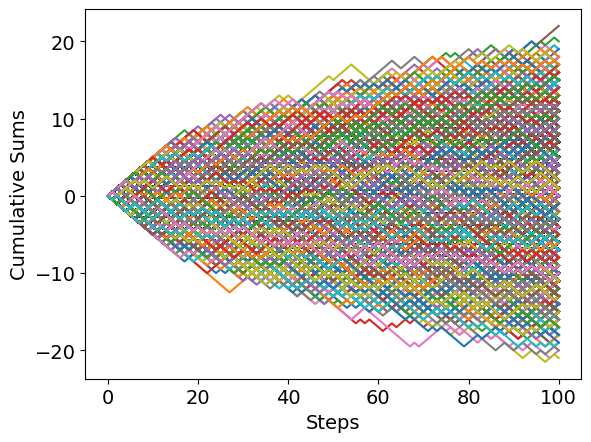

In [7]:
n = 1
nwalks = 10**5
nsamples = 100
steps_vals = np.zeros((nwalks, nsamples))
S = np.zeros(nwalks)
rand_walk_for_plot = np.zeros((nwalks, nsamples+1))

for ii in range(nwalks):
    steps_vals[ii,:] = generate_random_walk_steps(nsamples)
    S[ii] = sum(steps_vals[ii,:])
    rand_walk_for_plot[ii] = generate_random_walk(generate_random_walk_steps(nsamples), 4)

# print(steps_vals)
# print(S)
# print(rand_walk_for_plot)

tplot = np.linspace(0, nsamples, nsamples+1)
plt.plot(tplot, rand_walk_for_plot.T, n)
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Cumulative Sums', fontsize=14)

### (b) Compute Probability P(S > 10) with Simple Monte Carlo Method

Now we estimate the probability $P(S > 10)$ using Monte Carlo simulation with $10^5$ trials:

In [8]:
ntrials = 10**5
g_x = np.zeros(ntrials)
cumsum_step_vals = np.cumsum(steps_vals, 1)
for jj in range(ntrials):
    if cumsum_step_vals[jj,-1] > 10:
        g_x[jj] = 1
    else:
        g_x[jj] = 0
#plt.figure(cumsum_step_vals)
prob_greater_10 = np.sum(g_x)/ntrials
print(prob_greater_10)
print(g_x)
print(g_x.shape)


0.13569
[0. 1. 0. ... 1. 0. 0.]
(100000,)


### (c) Compute Probability P(S > 55) with Importance Sampling

Next, we estimate the probability $P(S > 55)$ using Importance Sampling with $10^5$ trials:

In [9]:
def sampling_proposal_distribution(num_steps):
    X_prop_dist = np.random.rand(num_steps) # samples from a uniform
    # Inverse CDF Trick
    X_prop_dist[X_prop_dist > 0.25] = 1.0
    X_prop_dist[X_prop_dist < 0.25] = -1.0
    return X_prop_dist

In [12]:
ntrials = 10**5
nsamples = 100
steps_vals_prop_dist = np.zeros((ntrials, nsamples))
S_pd = np.zeros(ntrials)
# plt.figure()

for kk in range(ntrials):
    steps_vals_prop_dist[kk,:] = sampling_proposal_distribution(nsamples)
    S_pd[kk] = sum(steps_vals_prop_dist[kk,:])
print(steps_vals_prop_dist)
print(S_pd)

[[-1.  1. -1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ... -1.  1.  1.]
 ...
 [ 1. -1. -1. ...  1.  1.  1.]
 [ 1. -1. -1. ...  1.  1.  1.]
 [ 1. -1.  1. ...  1.  1.  1.]]
[66. 54. 68. ... 52. 46. 70.]


In [13]:
f_X = 0.5**nsamples
ntrials = 100000
pi_X = np.zeros((ntrials,1))

for jj in range(ntrials):
    c_plus1 = np.count_nonzero(steps_vals_prop_dist[jj,:] == 1)
    c_minus1 = np.count_nonzero(steps_vals_prop_dist[jj,:] == -1)
    pi_X[jj] = 0.75**c_plus1 * 0.25**c_minus1
    
likelihood_ratio = f_X/pi_X
print(likelihood_ratio)

[[3.17640174e-10]
 [2.31559687e-07]
 [1.05880058e-10]
 ...
 [6.94679060e-07]
 [1.87563346e-05]
 [3.52933526e-11]]


In [14]:
g_x_55 = np.zeros(ntrials)
evals_55 = np.zeros(ntrials)
cumsum_step_vals_prop_dist = np.cumsum(steps_vals_prop_dist, 1)
for jj in range(ntrials):
    if cumsum_step_vals_prop_dist[jj,-1] > 55:
        g_x_55[jj] = 1
    else:
        g_x_55[jj] = 0

g_x_55 = g_x_55.reshape(1,-1)
evals_55 = np.matmul(g_x_55,likelihood_ratio)   
prob_greater_55 = evals_55/ntrials

print(g_x_55.shape)
print(likelihood_ratio.shape)
print(evals_55)
print(prob_greater_55)

(1, 100000)
(100000, 1)
[[0.00079666]]
[[7.96655734e-09]]


### (d) Analytical Expressions for the Probabilities

By calculating analytically, we realize that positions at even time-steps are always even and positions at odd time-steps are always odd in a 1-D Bernoulli random walk. Therefore, the event never occurs for $N$ equal to 100. 

In [15]:
#Analytical expressions
Anex_count_10 = 0
for ii in range(56, 100):
    Anex_count_10 = Anex_count_10 + math.comb(100,ii)
Anex_prob_10 = (0.5**(100))*Anex_count_10
print(Anex_count_10)
print(Anex_prob_10)

171927029390459478008041362799
0.13562651203691736


In [16]:
Anex_count_55 = 0
for ii in range(78, 100):
    Anex_count_55 = Anex_count_55 + math.comb(100,ii)
Anex_prob_55 = (0.5**(100))*Anex_count_55
print(Anex_count_55)
print(Anex_prob_55)

10081199593311073579495
7.95266423689307e-09


### Problem 2.1 e (i)

### (e) Error Estimates in Monte Carlo Probabilities

#### (i) Monte Carlo Standard Error and Confidence Interval

Firstly, we calculate the Monte Carlo standard error for each estimate. Then we can use the central limit theorem to write an approximate 95% confidence interval for the desired probability:


In [17]:
# Estimate Monte Carlo Error in estimate for P(S>10)
mc_error_10 = np.var(g_x)/ntrials
# Estimate Monte Carlo Error in estimate for P(S>10)
mc_error_55 = np.var(g_x_55)/ntrials
# z = 2 for 95% confidence interval
left_ci_10 = prob_greater_10 + 2*((mc_error_10)**(1/2))
right_ci_10 = prob_greater_10 - 2*((mc_error_10)**(1/2))

left_ci_55 = prob_greater_55 + 2*((mc_error_55)**(1/2))
right_ci_55 = prob_greater_55 - 2*((mc_error_55)**(1/2))
print(mc_error_10)
print(left_ci_10)
print(right_ci_10)
print(mc_error_55)
print(left_ci_55)
print(right_ci_55)

1.172782239e-06
0.13785590141880927
0.13352409858119074
2.037620991e-06
[[0.00285491]]
[[-0.0028549]]


### Problem 2.1 e(ii)

(ii) Independent Replicates of Monte Carlo Estimators:

Next, we run at least 1000 independent replicates of our Monte Carlo estimators. For each replication, we compute a 95% confidence interval for the desired probability.

In [18]:
ntrials = 10**5
nsamples = 100
replicate = 1000
count_2_1b = 0
count_2_1c = 0
steps_vals_2_1b = np.zeros((ntrials, nsamples))
g_x_2_1_b = np.zeros((ntrials,1))

for ii in range(replicate):
    # For 2.1b
    for jj in range(ntrials):
        steps_vals_2_1b[jj,:] = generate_random_walk_steps(nsamples)

    cumsum_step_vals_2_1b = np.cumsum(steps_vals_2_1b, 1)
    for jj in range(ntrials):
            if cumsum_step_vals_2_1b[jj,-1] > 10:
                g_x_2_1_b[jj] = 1
            else:
                g_x_2_1_b[jj] = 0

    prob_2_1_b = np.sum(g_x_2_1_b)/ntrials
    mc_err_2_1b = np.var(g_x_2_1_b)/ntrials
    left_ci_2_1b = prob_2_1_b - 2*((mc_err_2_1b)**(1/2))
    right_ci_2_1b = prob_2_1_b + 2*((mc_err_2_1b)**(1/2))
    
    if Anex_prob_10 >= left_ci_2_1b and Anex_prob_10 <= right_ci_2_1b:
        count_2_1b += 1 
    else:
        count_2_1b += 0
    
    # For 2.1c 
    steps_vals_2_1c = np.zeros((ntrials, nsamples))
    for jj in range(ntrials):
        steps_vals_2_1c[jj,:] = sampling_proposal_distribution(nsamples)

    f_X_2e = 0.5**nsamples
    pi_X_2e = np.zeros((ntrials,1))

    for jj in range(ntrials):
        c_plus1_2e = np.count_nonzero(steps_vals_prop_dist[jj,:] == 1)
        c_minus1_2e = np.count_nonzero(steps_vals_prop_dist[jj,:] == -1)
        pi_X_2e[jj] = 0.75**c_plus1_2e * 0.25**c_minus1_2e
    likelihood_ratio_2e = f_X_2e/pi_X_2e

    g_x_2_1_c = np.zeros(ntrials)
    evals_2_1_c = np.zeros(ntrials)
    cumsum_step_vals_prop_dist = np.cumsum(steps_vals_prop_dist, 1)
    for jj in range(ntrials):
        if cumsum_step_vals_prop_dist[jj,-1] > 55:
            g_x_2_1_c[jj] = 1
        else:
            g_x_2_1_c[jj] = 0

    g_x_2_1_c = g_x_2_1_c.reshape(1,-1)
    evals_2_1_c = np.matmul(g_x_2_1_c,likelihood_ratio_2e)   
    prob_2_1_c = evals_2_1_c/ntrials

    mc_err_2_1c = np.var(g_x_2_1_c)/ntrials
    left_ci_2_1c = prob_2_1_c - 2*((mc_err_2_1c)**(1/2))
    right_ci_2_1c = prob_2_1_c + 2*((mc_err_2_1c)**(1/2))
    
    if Anex_prob_55 >= left_ci_2_1c and Anex_prob_55 <= right_ci_2_1c:
        count_2_1c += 1 
    else:
        count_2_1c += 0
    
print(count_2_1b)
print(count_2_1c)

956
1000


### Problem 2.1 e(iii)

(iii) Running Mean Estimators

Finally, we consider the running mean estimators from 1 to $10^5$ trials in each of our 1000 independent sequences:

In [20]:
ntrials = 10**5
nsamples = 100
replicate = 1000
count_21b = 0
count_21c = 0
steps_vals_21b = np.zeros((ntrials, nsamples))
g_x_21b = np.zeros((ntrials,1))
den_S_run_21b = np.arange((1, ntrials+1))
Sn_running_21b = np.zeros((ntrials, nsamples))

for ii in range(replicate):
    # For 2.1b
    for jj in range(ntrials):
        steps_vals_21b[jj,:] = generate_random_walk_steps(nsamples)

    cumsum_step_vals_21b = np.cumsum(steps_vals_21b, 1)
    g_x_21b = cumsum_step_vals_21b[jj,-1] > 10
    prob_21b = np.sum(g_x_21b)/ntrials
    Sn_running_21b[ii,:] = np.cumsum(g_x_21b)/den_S_run_21b
    
    mc_err_2_1b = np.var(g_x_21b)/ntrials
    left_ci_2_1b = prob_21b - 2*((mc_err_2_1b)**(1/2))
    right_ci_2_1b = prob_21b + 2*((mc_err_2_1b)**(1/2))
    
    if Anex_prob_10 >= left_ci_2_1b and Anex_prob_10 <= right_ci_2_1b:
        count_21b += 1 
    else:
        count_21b += 0
    
Sn_running_mean_21b = np.sum(Sn_running_21b[:,-1])/replicates
Sn_running_mean_21b_sorted = np.sort(Sn_running_21b[:,-1])
right_i = Sn_running_mean_21b_sorted[975] - Sn_running_mean_21b
left_i = Sn_running_mean_21b - Sn_running_mean_21b_sorted[25]
print(right_i)    
print(left_i)


TypeError: arange: scalar arguments expected instead of a tuple.